In [ ]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: NVIDIA A100-SXM4-40GB


In [ ]:
df = pd.read_csv('/content/temizlendi_correctyapıldı_stoplarfalan_silinmedi_sadece1kere_gecenler_silindi.csv')

In [ ]:
df = df.rename(columns={'idea': 'Category', 'sentence': 'Message'})
df.head()

,Unnamed: 0,Message,Category
0,1,we are clearly having a abc correction after w...,Short
1,2,we all know etc needs some correction order bl...,Short
2,3,hello traders on the daily time frame the btcu...,Short
3,4,the first day of the week has started with a v...,Short
4,5,a lot of investors are getting optimistic view...,Short


In [ ]:
df.Category.value_counts()

Long     3473
Short    2670
Name: Category, dtype: int64

In [ ]:
df.Category.value_counts(normalize=True)

Long     0.565359
Short    0.434641
Name: Category, dtype: float64

In [ ]:
df_short = df[df['Category']=='Short']
df_long = df[df['Category']=='Long']
df_long_downsampled = df_long.sample(df_short.shape[0])
df= pd.concat([df_long_downsampled, df_short])
df['Category'].value_counts()

Long     2670
Short    2670
Name: Category, dtype: int64

In [ ]:
df= df.reset_index(drop=True)

In [ ]:
df

,Unnamed: 0,Message,Category
0,720,hi all it s been a while since i ve posted som...,Long
1,1526,so first and foremost let me state that i did ...,Long
2,2138,compliance lawsuit and full disclosure for eve...,Long
3,2602,hello traders after having a look at btcusd it...,Long
4,4723,hello guns here is another marked made on bitc...,Long
...,...,...,...
5335,6136,hi i see a very good trade opportunity risk to...,Short
5336,6137,possible etc rejection there at the h s resist...,Short
5337,6140,another close up view maybe i m wrong maybe no...,Short
5338,6142,it is expected that the price will change the ...,Short


In [ ]:
df=df.rename(columns={"Message": "text", "Category": "category"})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5340 entries, 0 to 5339
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5340 non-null   int64 
 1   text        5338 non-null   object
 2   category    5340 non-null   object
dtypes: int64(1), object(2)
memory usage: 125.3+ KB


In [ ]:
df=df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5338 entries, 0 to 5339
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5338 non-null   int64 
 1   text        5338 non-null   object
 2   category    5338 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.8+ KB


In [ ]:
df.category.value_counts(normalize=True)

Short    0.500187
Long     0.499813
Name: category, dtype: float64

In [ ]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])

In [ ]:
df

,Unnamed: 0,text,category,encoded_categories
0,720,hi all it s been a while since i ve posted som...,Long,0
1,1526,so first and foremost let me state that i did ...,Long,0
2,2138,compliance lawsuit and full disclosure for eve...,Long,0
3,2602,hello traders after having a look at btcusd it...,Long,0
4,4723,hello guns here is another marked made on bitc...,Long,0
...,...,...,...,...
5335,6136,hi i see a very good trade opportunity risk to...,Short,1
5336,6137,possible etc rejection there at the h s resist...,Short,1
5337,6140,another close up view maybe i m wrong maybe no...,Short,1
5338,6142,it is expected that the price will change the ...,Short,1


In [ ]:
df['length']=df.text.apply(lambda x: len(x))

In [ ]:
df

,Unnamed: 0,text,category,encoded_categories,length
0,720,hi all it s been a while since i ve posted som...,Long,0,1071
1,1526,so first and foremost let me state that i did ...,Long,0,1041
2,2138,compliance lawsuit and full disclosure for eve...,Long,0,2286
3,2602,hello traders after having a look at btcusd it...,Long,0,744
4,4723,hello guns here is another marked made on bitc...,Long,0,105
...,...,...,...,...,...
5335,6136,hi i see a very good trade opportunity risk to...,Short,1,72
5336,6137,possible etc rejection there at the h s resist...,Short,1,55
5337,6140,another close up view maybe i m wrong maybe no...,Short,1,177
5338,6142,it is expected that the price will change the ...,Short,1,138


In [ ]:
df.text[4]

'hello guns here is another marked made on bitcoin price wicked creating liquidity level and is heading up'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sentences = df.text.values

In [ ]:
max_len=395

In [ ]:
training = df.groupby('category').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

print("Training: ", len(training))
print("Test: ", len(test))

training_texts = training.text.values
training_labels = training.encoded_categories.values

Training:  4270
Test:  1068


In [ ]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  etc on the month chart using ma roi and stock roi red circles sell region green circles buy region white box indicator of bull run red circles sell areas when roi peaks over this is signal when stock roi is over and the blue line crosses below the red line this is signal when both signals trigger this marks the market top was the only time where the roi peaked over a second time while the stock crossed at this resulted in a second top in green circles buy area when roi lips under this is signal when stock roi falls under and the blue line crosses above the red line this is signal when both signals trigger this means market has bottom also of note when price falls below the ma that is a good time to be accumulation white bull run in the roi when the green line crosses above the red line that s signal in the stock roi when the blue line crosses above the orange dotted line that s signal when both the roi and stock signals confirm this marks bull run in the rules for market bot

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

number_of_categories = len(df['encoded_categories'].unique())

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = number_of_categories,
    output_attentions = False,
    output_hidden_states = False,
    ignore_mismatched_sizes=True

)

model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

In [ ]:
epochs = 10

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 10 ========
Batch    10  of    134.    Elapsed: 0:00:07.
Batch    20  of    134.    Elapsed: 0:00:12.
Batch    30  of    134.    Elapsed: 0:00:17.
Batch    40  of    134.    Elapsed: 0:00:22.
Batch    50  of    134.    Elapsed: 0:00:27.
Batch    60  of    134.    Elapsed: 0:00:32.
Batch    70  of    134.    Elapsed: 0:00:37.
Batch    80  of    134.    Elapsed: 0:00:42.
Batch    90  of    134.    Elapsed: 0:00:48.
Batch   100  of    134.    Elapsed: 0:00:53.
Batch   110  of    134.    Elapsed: 0:00:58.
Batch   120  of    134.    Elapsed: 0:01:03.
Batch   130  of    134.    Elapsed: 0:01:08.
Average training loss: 0.67
Training epoch took: 0:01:10
======== Epoch 2 / 10 ========
Batch    10  of    134.    Elapsed: 0:00:05.
Batch    20  of    134.    Elapsed: 0:00:10.
Batch    30  of    134.    Elapsed: 0:00:15.
Batch    40  of    134.    Elapsed: 0:00:20.
Batch    50  of    134.    Elapsed: 0:00:26.
Batch    60  of    134.    Elapsed: 0:00:31.
Batch    70  of    134.   

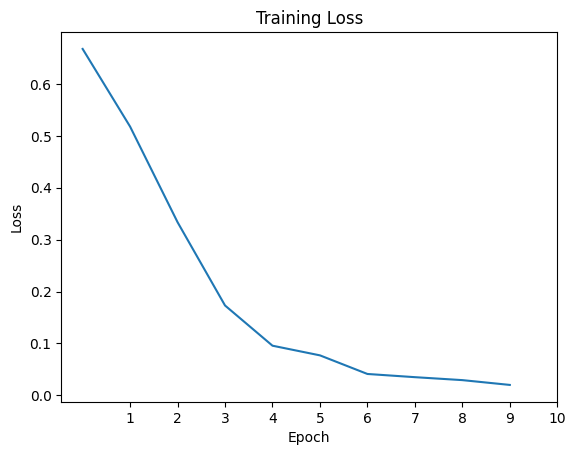

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

In [ ]:
test_texts = test.text.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [ ]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'long',
                          '1':'short',
                          })

print(report)

F-Score:  0.8080239904248743
Recall:  0.8080524344569289
Precision:  0.8082351124788147
                 long       short  accuracy    macro avg  weighted avg
precision    0.815739    0.800731  0.808052     0.808235      0.808235
recall       0.795880    0.820225  0.808052     0.808052      0.808052
f1-score     0.805687    0.810361  0.808052     0.808024      0.808024
support    534.000000  534.000000  0.808052  1068.000000   1068.000000


In [ ]:
report

,long,short,accuracy,macro avg,weighted avg
precision,0.815739,0.800731,0.808052,0.808235,0.808235
recall,0.795880,0.820225,0.808052,0.808052,0.808052
f1-score,0.805687,0.810361,0.808052,0.808024,0.808024
support,534.000000,534.000000,0.808052,1068.000000,1068.000000


In [ ]:
#375 kelime 10 epoch ile 14.6 gpu kullandı ve çalıştı. 400 kelimede çalışmadı